In [1]:
import numpy as np
import os, glob
import open3d as o3d
import sys
from numpy import fromfile
from matplotlib import pyplot as plt 

import random
import sys
# Set the path to the mavs python api, mavs_interface.py
# you will have to change this on your system
sys.path.append(r'/home/jinhee/mavs/src/mavs_python/')
# Load the mavs python modules
import mavs_interface as mavs
import mavs_python_paths

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
sequence_num="01"

mavs_class_dict ={
    1: "rough trail",
    2: "low vegetation",
    3: "high vegetation",
    4: "smooth trail",
    5: "obstacle",    
    6: "vehicle",
    7: "dust",
    8: "stop_sign",
    9: "yield_sign",
    10: "building",
    11: "pedestrian",
    12: "fence",
    13: "pothole"
}


In [3]:
lidar = mavs.MavsLidar('VLP-16')
lidar.SetScanPattern(-180.0, 180.0, 0.1, -15, 15, 2.0)

In [4]:
%%time
lidar.SetOffset([0.0, 0.0, 1.2],[1.0,0.0,0.0,0.0])

# Select a scene and load it
mavs_scenefile = '../../../../../scene_files/'+sequence_num+'/mavs_scene'+sequence_num+'_scene.json' 

# Set the path to the mavs data folder
mavs_data_path = mavs_python_paths.mavs_data_path

# Select a scene and load it
scene = mavs.MavsEmbreeScene()
scene.Load(mavs_scenefile)
scene.TurnOnLabeling()

#--- Load the waypoints that go with this scene ----#
waypoints = mavs.MavsWaypoints()
waypoints.Load('./mavs_scene'+sequence_num+'_path.vprp')
waypoints.PutWaypointsOnGround(scene)

# Create a MAVS environment and add the scene to it
env = mavs.MavsEnvironment()
env.SetScene(scene.scene)

# loop over all the poses in the waypoints list
for i in range(waypoints.num_waypoints):
    print(i)
    if i == 10:
        current_position = waypoints.GetWaypoint(i)
        current_orient = waypoints.GetOrientation(i)

        #Set pose of the lidar and scan a frame, saving labeledpoints
        lidar.SetPose(current_position,current_orient)
        lidar.Update(env,0.1)
        lidar.AnnotateFrame(env)
        lidar.AnalyzeCloud('labeled_lidar',i,False)
        lidar.SetDisplayColorType('label')
        lidar.DisplayPerspective()

        lidar.SaveProjectedLidarImage('./bmp/'+str(i).zfill(4)+'.bmp')
        lidar.SavePcd('../pcd_velodyne/'+str(i).zfill(6)+'.pcd')
        lidar.SaveLabeledPcd('./labeledpcd/labeled_lidar'+str(i).zfill(4)+'.pcd')


WARNING, setting scene with pointer may cause seg fault if scene goes out of scope!
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
25

In [5]:
%%time

np_all_bins=[]
np_all_labels=[]

for file in sorted(glob.glob("./labeled*.txt")): 
    # Text file data converted to integer data type
    File_data = np.loadtxt(file, dtype=float)
    npy_file_name = "../velodyne/"+os.path.basename(file[-10:-4])+".bin"
    npy_label_file_name = "../labels/"+os.path.basename(file[-10:-4])+".label"

    np_all_bins = np.array(File_data[:,:4], dtype=np.float32)
    np_all_labels = np.array(File_data[:,4], dtype=np.uint32)

    with open(npy_file_name, 'wb') as f:
        f.write(np_all_bins)
    
    with open(npy_label_file_name, 'wb') as f:
        f.write(np_all_labels)
    
    print(f"processing {file}...")

processing ./labeled_lidar000000.txt...
processing ./labeled_lidar000001.txt...
processing ./labeled_lidar000002.txt...
processing ./labeled_lidar000003.txt...
processing ./labeled_lidar000004.txt...
processing ./labeled_lidar000005.txt...
processing ./labeled_lidar000006.txt...
processing ./labeled_lidar000007.txt...
processing ./labeled_lidar000008.txt...
processing ./labeled_lidar000009.txt...
processing ./labeled_lidar000010.txt...
processing ./labeled_lidar000011.txt...
processing ./labeled_lidar000012.txt...
processing ./labeled_lidar000013.txt...
processing ./labeled_lidar000014.txt...
processing ./labeled_lidar000015.txt...
processing ./labeled_lidar000016.txt...
processing ./labeled_lidar000017.txt...
processing ./labeled_lidar000018.txt...
processing ./labeled_lidar000019.txt...
processing ./labeled_lidar000020.txt...
processing ./labeled_lidar000021.txt...
processing ./labeled_lidar000022.txt...
processing ./labeled_lidar000023.txt...
processing ./labeled_lidar000024.txt...


In [6]:
unique, counts = np.unique(np_all_labels, return_counts=True)
print(unique, counts)
D = { y_str:count for y_str, count in zip(mavs_class_dict.values(), counts[1:])}

print(D)

[0 1 2 3 4 5] [15674 23010  1812 15236  1280   604]
{'rough trail': 23010, 'low vegetation': 1812, 'high vegetation': 15236, 'smooth trail': 1280, 'obstacle': 604}


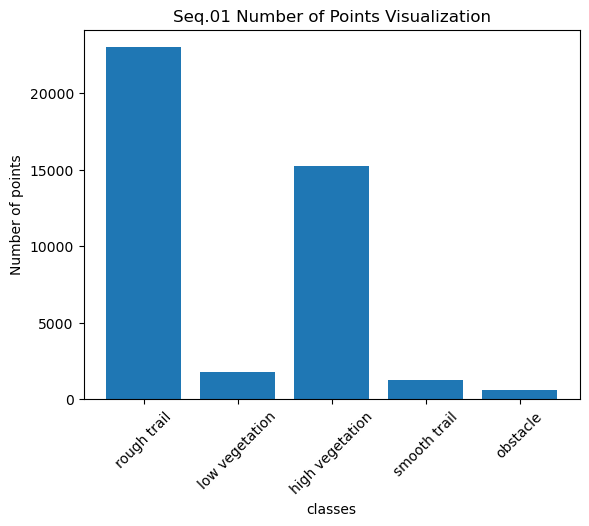

Total number of points of 01: 57616

<<Number of points according to each classes>>
 {'rough trail': 23010, 'low vegetation': 1812, 'high vegetation': 15236, 'smooth trail': 1280, 'obstacle': 604}

Seq.01: The number of the classes : 6


In [7]:
img_title="Seq."+sequence_num+" Number of Points Visualization"
num_classes = len(unique)
n_classes = len(unique)

plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()),rotation = 45)
plt.xlabel('classes')
plt.ylabel('Number of points')
plt.title (img_title)

img_save_path='../meta_data/'+img_title+'.png'
plt.savefig(img_save_path, bbox_inches='tight', format="png")
plt.show()

print(f"Total number of points of {sequence_num}: {len(np_all_labels)}\n")
print(f"<<Number of points according to each classes>>\n {D}\n")
print(f"Seq.{sequence_num}: The number of the classes : {num_classes}")

with open("../meta_data/analysis.txt", "w") as f:
    print(f"Total number of points of {sequence_num}: {len(np_all_labels)}\n",file=f)
    print(f"<<Number of points according to each classes>>\n {D}\n",file=f)
    print(f"Seq.{sequence_num}: The number of the classes : {num_classes}",file=f)